In [1]:
import uproot
import matplotlib.pyplot as plt 
import matplotlib as mpl
import mplhep as hep
import numpy as np
import fnmatch
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm
import hist
import pickle as pkl
import pandas as pd
import os

In [10]:
idx_u0 = 0 
idx_v0 = 1984
idx_w0 = 3968
idx_u1 = 5632
idx_v1 = 7616
idx_w1 = 9000

def u_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    tpc1_arr = input[idx_u1:idx_v1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def v_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    tpc1_arr = input[idx_v1:idx_w1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def w_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    tpc1_arr = input[idx_w1:]
    return np.concatenate([tpc0_arr,tpc1_arr])

def u0_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    return tpc0_arr

def v0_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    return tpc0_arr

def w0_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    return tpc0_arr

def u1_ch(input): 
    tpc1_arr = input[idx_u1:idx_v1]
    return tpc1_arr

def v1_ch(input): 
    tpc1_arr = input[idx_v1:idx_w1]
    return tpc1_arr

def w1_ch(input): 
    tpc1_arr = input[idx_w1:]
    return tpc1_arr

def quartile_reso(data):
    data = np.round(np.sort(data),3)
    median = np.median(data)
    median_idx = int(np.round(len(data)/2))
    quar_size =  int(np.round(len(data)*0.5*0.683))
    Q1 = data[median_idx - quar_size]
    Q3 = data[median_idx + quar_size]
    quartile_reso = np.sqrt(0.5*(median-Q1)**2 + 0.5*(median-Q3)**2)
    return quartile_reso

def find_nonzero_ch(wvfm):
    # peak threshold = 800
    mask = (wvfm > 800).sum(axis = 1)
    return np.where(mask>0)[0]

In [3]:
# with open("electron_caf.list") as f:
with open("electron_caf_edited.list") as f:
    caf_list = f.read().split('\n')

with open("electron_wvfm.list") as f:
    wvfm_list = f.read().split('\n')

In [4]:
nfiles = 1
N = 20*nfiles*2 # number of events * number of files * 2 particles per event
u_diff_arr = np.zeros(N)
v_diff_arr = np.zeros(N)
w_diff_arr = np.zeros(N)
theta_xz_arr = np.zeros(N)
depE_arr = np.zeros(N)
subrun_arr = np.zeros(N)

for i in tqdm(range(9,10)):
    wvfm = uproot.open(wvfm_list[i])
    dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
    sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')

    # caf = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03_02/electron_gun/electron_caf/3414904_0/prodsingle_sbnd_SinglesGen-20230812T042829_G4-20230812T043429_WCLS-20230812T050513_405fd978-8f82-4ce9-9dc6-70c89057648f.flat.caf.root:recTree")
    caf = uproot.open(caf_list[i]+":recTree")
    tree = caf.arrays(["rec.hdr.run",
                            "rec.hdr.subrun",
                            "rec.hdr.evt",    
                            "rec.mc.nu.prim.startp.x" ,
                            "rec.mc.nu.prim.startp.y",
                            "rec.mc.nu.prim.startp.z",
                            "rec.mc.nu.prim.startE",
                            "rec.mc.nu.prim.endE"],library='pd')

    tree["theta_xz"] = np.arctan(abs(tree["rec.mc.nu.prim.startp.x"]/tree["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
    tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]
    

    for event in range(len(dec_names)):
        evt_sim = wvfm[sim_names[event]].values()
        u0_sim = np.sum(u0_ch(evt_sim)); v0_sim = np.sum(v0_ch(evt_sim)); w0_sim = np.sum(w0_ch(evt_sim))
        u1_sim = np.sum(u1_ch(evt_sim)); v1_sim = np.sum(v1_ch(evt_sim)); w1_sim = np.sum(w1_ch(evt_sim))

        evt_dec = wvfm[dec_names[event]].values()*50
        u0_dec = np.sum(u0_ch(evt_dec)); v0_dec = np.sum(v0_ch(evt_dec)); w0_dec = np.sum(w0_ch(evt_dec))
        u1_dec = np.sum(u1_ch(evt_dec)); v1_dec = np.sum(v1_ch(evt_dec)); w1_dec = np.sum(w1_ch(evt_dec))

        # this_df = tree["rec.hdr.evt" == event]
        # tpc0_df, tpc1_df = caf_split_tpc(this_df)
        
        # tpc 0
        i=0
        u_diff_arr[i*40 + 2*event+1]   = (u0_dec - u0_sim)/u0_dec
        v_diff_arr[i*40 + 2*event+1]   = (v0_dec - v0_sim)/v0_dec
        w_diff_arr[i*40 + 2*event+1]   = (w0_dec - w0_sim)/w0_dec
        theta_xz_arr[i*40 + 2*event+1] = tree.iloc[2*event+1]["theta_xz"]
        depE_arr[i*40 + 2*event+1] = tree.iloc[2*event+1]["depE"]

        # tpc 1
        u_diff_arr[i*40 + 2*event]   = (u1_dec - u1_sim)/u1_dec
        v_diff_arr[i*40 + 2*event]   = (v1_dec - v1_sim)/v1_dec
        w_diff_arr[i*40 + 2*event]   = (w1_dec - w1_sim)/w1_dec
        theta_xz_arr[i*40 + 2*event] = tree.iloc[2*event]["theta_xz"]
        depE_arr[i*40 + 2*event] = tree.iloc[2*event]["depE"]
        
        subrun = tree.iloc[0]["rec.hdr.subrun"]
        subrun_arr[i*40 + 2*event] = tree.iloc[0]["rec.hdr.subrun"]
    df = pd.DataFrame({'sub' : subrun_arr,'u': u_diff_arr, 'v': v_diff_arr, 'w': w_diff_arr,
                   "theta_xz" : theta_xz_arr, 'depE' : depE_arr})
    # df.to_pickle("pkl_files/subrun_"+str(int(subrun))+".pkl")    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df[df.u > 0]

,sub,u,v,w,theta_xz,depE
36,198.0,0.005567,0.178208,-0.011272,51.135525,0.106951


In [ ]:
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

In [ ]:
idx = 37
evtnum = idx//2
tpcnum = idx%2
nonzeroch = find_nonzero_ch(wvfm[sim_names[evtnum]].values())

sim_arr = wvfm[sim_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[sim_names[evtnum]].values()[idx_u1:,:]
dec_arr = wvfm[dec_names[evtnum]].values()[:idx_u1,:]*50 if tpcnum == 0 else wvfm[dec_names[evtnum]].values()[idx_u1:,:]*50
raw_arr = wvfm[raw_names[evtnum]].values()[:idx_u1,:] if tpcnum == 0 else wvfm[raw_names[evtnum]].values()[idx_u1:,:]
print("sim sum for event", np.sum(sim_arr))
print("dec sum for event", np.sum(dec_arr))

sim_sum = np.sum(wvfm[sim_names[evtnum]].values()[nonzeroch],axis=1)     # array of sim sum of each channel
dec_sum = np.sum(wvfm[dec_names[evtnum]].values()[nonzeroch],axis=1)*50  # array of dec sum of each channel
over_mask = np.where((dec_sum - sim_sum)/sim_sum > 0,True,False)         # mask of channels that are over
over_arr = nonzeroch[np.where((dec_sum - sim_sum)/sim_sum > 0,True,False)]

sim sum for event 8244125.0
dec sum for event 8824175.0


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


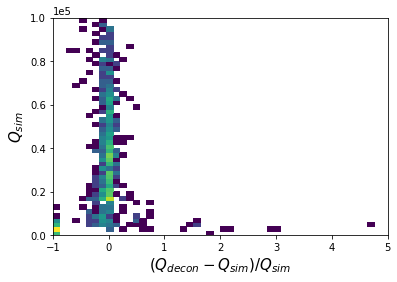

In [ ]:
plt.hist2d(((dec_sum - sim_sum)/sim_sum), sim_sum,bins=50,range=[[-1,5],[0,1e5]],norm=mpl.colors.LogNorm())
plt.xlabel(r"$(Q_{decon} - Q_{sim} )/ Q_{sim}$",fontsize=15)
plt.ylabel(r"$Q_{sim}$",fontsize=15)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

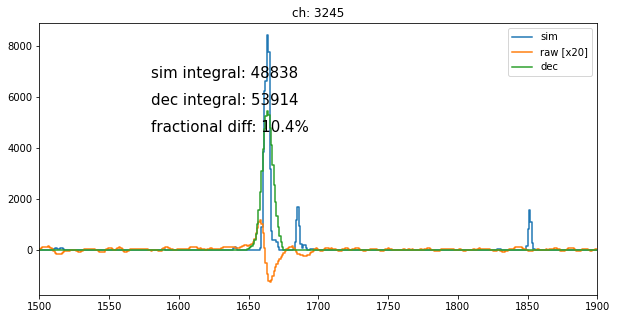

In [ ]:
over_idx = 81
chnum = over_arr[over_idx]

plt.figure(figsize=(10,5))
hep.histplot(wvfm[sim_names[evtnum]].values()[chnum]   ,label="sim")
hep.histplot(wvfm[raw_names[evtnum]].values()[chnum]*20,label="raw [x20]")
hep.histplot(wvfm[dec_names[evtnum]].values()[chnum]*50,label="dec")

sim_ch_sum = np.sum(wvfm[sim_names[evtnum]].values()[chnum])
dec_ch_sum = np.sum(wvfm[dec_names[evtnum]].values()[chnum]*50)
diff_ch = (dec_ch_sum - sim_ch_sum)/sim_ch_sum

plt.annotate(f"sim integral: {sim_ch_sum:.0f}",(0.2,0.8) ,xycoords='axes fraction',fontsize=15)
plt.annotate(f"dec integral: {dec_ch_sum:.0f}",(0.2,0.7),xycoords='axes fraction',fontsize=15)
plt.annotate(f"fractional diff: {diff_ch*100:.1f}%",(0.2,0.6),xycoords='axes fraction',fontsize=15)
plt.title(f"ch: {chnum}")
plt.xlim(1500,1900)
# plt.xlim(1700,2000)
plt.legend()
plt.show()

In [ ]:
np.sum(wvfm[sim_names[evtnum]].values()[chnum][16:1900])

48837.992

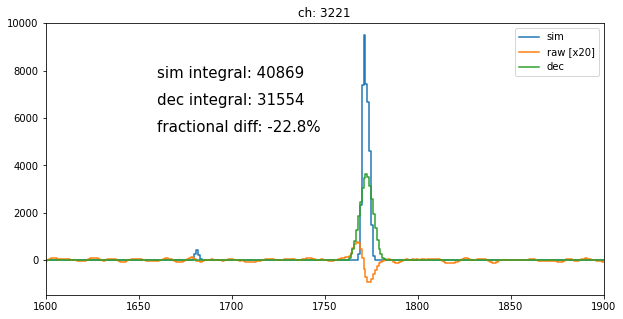

In [ ]:
chnum = 3221

plt.figure(figsize=(10,5))
hep.histplot(wvfm[sim_names[evtnum]].values()[chnum]   ,label="sim")
hep.histplot(wvfm[raw_names[evtnum]].values()[chnum]*20,label="raw [x20]")
hep.histplot(wvfm[dec_names[evtnum]].values()[chnum]*50,label="dec")

sim_ch_sum = np.sum(wvfm[sim_names[evtnum]].values()[chnum])
dec_ch_sum = np.sum(wvfm[dec_names[evtnum]].values()[chnum]*50)
diff_ch = (dec_ch_sum - sim_ch_sum)/sim_ch_sum

plt.annotate(f"sim integral: {sim_ch_sum:.0f}",(0.2,0.8) ,xycoords='axes fraction',fontsize=15)
plt.annotate(f"dec integral: {dec_ch_sum:.0f}",(0.2,0.7),xycoords='axes fraction',fontsize=15)
plt.annotate(f"fractional diff: {diff_ch*100:.1f}%",(0.2,0.6),xycoords='axes fraction',fontsize=15)
plt.title(f"ch: {chnum}")
plt.xlim(1600,1900)
# plt.xlim(1300,1600)
plt.legend()
plt.show()

In [ ]:
print(np.sum(sim_arr[idx_v0:idx_w0,:]))
print(np.sum(dec_arr[idx_v0:idx_w0,:]))

4414315.5
4345580.0


In [ ]:
i = 9
caf = uproot.open(caf_list[i]+":recTree")
tree = caf.arrays(["rec.hdr.run",
                        "rec.hdr.subrun",
                        "rec.hdr.evt",    
                        "rec.mc.nu.prim.startp.x" ,
                        "rec.mc.nu.prim.startp.y",
                        "rec.mc.nu.prim.startp.z",
                        "rec.mc.nu.prim.startE",
                        "rec.mc.nu.prim.endE"],library='pd')

tree["theta_xz"] = np.arctan(abs(tree["rec.mc.nu.prim.startp.x"]/tree["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]
tree[tree.depE < 0.1]

rec.hdr.run  rec.hdr.subrun  rec.hdr.evt  \
entry subentry                                             
1     1                   1             197            2   
2     1                   1             197            3   
3     1                   1             197            4   
7     0                   1             197            8   
      1                   1             197            8   
15    0                   1             197           16   

                rec.mc.nu.prim.startp.x  rec.mc.nu.prim.startp.y  \
entry subentry                                                     
1     1                       -0.022458                      0.0   
2     1                       -0.015303                      0.0   
3     1                       -0.015390                      0.0   
7     0                        0.007171                      0.0   
      1                       -0.090727                      0.0   
15    0                        0.030829                      0.0   

                rec.mc.nu.prim.startp.z  rec.mc.nu.prim.startE  \
entry subentry                                                   
1     1                        0.020154               0.030180   
2     1                        0.074492               0.076049   
3     1                        0.032333               0.035812   
7     0                        0.039445               0.040095   
      1                        0.038153               0.098424   
15    0                        0.028127               0.041735   

                rec.mc.nu.prim.endE   theta_xz      depE  
entry subentry                                            
1     1                    0.000511  48.096146  0.029669  
2     1                    0.000511  11.608595  0.075538  
3     1                    0.000511  25.453472  0.035301  
7     0                    0.000511  10.303432  0.039584  
      1                    0.000511  67.191963  0.097913  
15    0                    0.000511  47.624577  0.041224

In [43]:
list_of_df = []
# iterate over files in directory
for filename in os.listdir("./pkl_files/"):
    list_of_df.append(pd.read_pickle("./pkl_files/" +filename))
df = pd.concat(list_of_df)
df

,file,sub,tpc,u,v,w,u_pur,v_pur,w_pur,u_eff,v_eff,w_eff,u_sim,v_sim,w_sim,u_dec,v_dec,w_dec,theta_xz,depE
0,0.0,1.0,0.0,-0.162706,-0.137464,-0.031118,100.000000,93.023256,100.000000,93.529412,90.909091,92.113565,1.487606e+07,1.485595e+07,1.485052e+07,12794337.0,13060585.0,14402347.0,9.203926,0.588769
1,0.0,1.0,0.0,-0.103411,-0.082413,-0.024883,100.000000,85.185185,100.000000,93.859649,94.845361,96.335079,5.114412e+06,5.109872e+06,5.130480e+06,4635091.0,4720817.0,5005916.0,28.056454,0.196424
2,0.0,1.0,0.0,-0.197037,-0.203959,-0.018610,99.206349,85.714286,100.000000,94.696970,90.000000,95.045045,1.496636e+07,1.496770e+07,1.496809e+07,12502837.0,12432063.0,14694621.0,32.165115,0.595075
3,0.0,1.0,0.0,-0.058878,-0.071130,-0.022175,98.425197,85.057471,100.000000,94.696970,89.156627,97.340426,5.743368e+06,5.715861e+06,5.743996e+06,5424011.0,5336290.0,5619388.0,37.196064,0.220303
4,0.0,1.0,0.0,-0.539941,-0.348128,-0.007962,97.530864,85.950413,100.000000,80.612245,87.394958,97.515528,2.593944e+07,2.597714e+07,2.601723e+07,16844440.0,19269040.0,25811716.0,67.693535,1.121240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,112.0,64.0,1.0,-0.023561,0.309429,-0.015903,100.000000,25.641026,100.000000,91.666667,83.333333,93.750000,5.659123e+05,5.684245e+05,5.702824e+05,552886.0,823122.0,561355.0,34.121407,0.023054
16,112.0,64.0,1.0,-0.281566,-0.317432,-0.027684,99.264706,88.571429,100.000000,92.465753,92.079208,89.671362,1.754765e+07,1.682526e+07,1.828211e+07,13692352.0,12771253.0,17789632.0,55.078888,0.681349
17,112.0,64.0,1.0,-0.578325,0.563560,-0.227358,100.000000,16.000000,99.047619,74.137931,50.000000,81.889764,1.707971e+07,1.269984e+05,3.405570e+07,10821414.0,290987.0,27747156.0,75.339325,0.854469
18,112.0,64.0,1.0,-0.420246,-0.292994,-0.016661,97.590361,83.620690,100.000000,81.000000,88.181818,90.510949,1.151255e+07,1.151199e+07,1.149040e+07,8106025.0,8903356.0,11302090.0,81.640228,0.527965


In [28]:
u_diff_arr = df["u"].to_numpy()
v_diff_arr = df["v"].to_numpy()
w_diff_arr = df["w"].to_numpy()

u_sim_arr = df["u_sim"].to_numpy()
v_sim_arr = df["v_sim"].to_numpy()
w_sim_arr = df["w_sim"].to_numpy()

u_dec_arr = df["u_dec"].to_numpy()
v_dec_arr = df["v_dec"].to_numpy()
w_dec_arr = df["w_dec"].to_numpy()

u_pur_arr = df["u_pur"].to_numpy()
v_pur_arr = df["v_pur"].to_numpy()
w_pur_arr = df["w_pur"].to_numpy()

u_eff_arr = df["u_eff"].to_numpy()
v_eff_arr = df["v_eff"].to_numpy()
w_eff_arr = df["w_eff"].to_numpy()

theta_xz_arr = df["theta_xz"].to_numpy()
depE_arr = df["depE"].to_numpy()

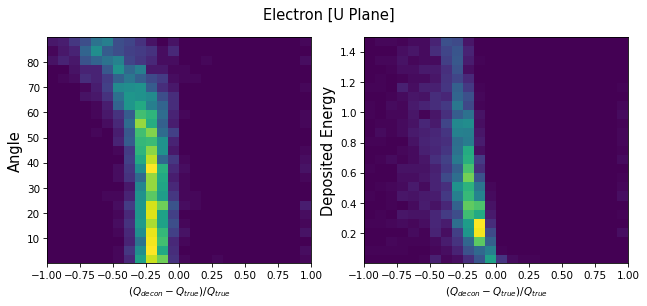

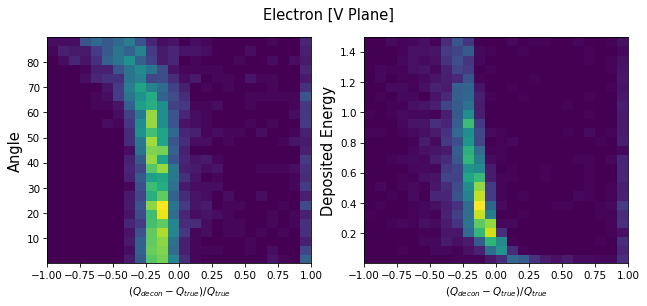

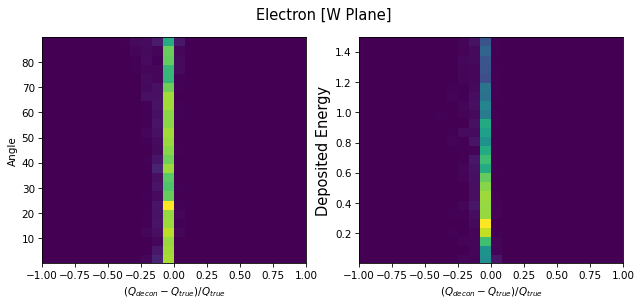

In [29]:
fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(u_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25])
axes[1].hist2d(u_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25])
axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

plt.suptitle("Electron [U Plane]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(v_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25])
axes[1].hist2d(v_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25])
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle",fontsize=14)
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle("Electron [V Plane]",fontsize=14)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4),dpi=75)
axes[0].hist2d(w_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25])
axes[1].hist2d(w_diff_arr,depE_arr,    bins=[np.linspace(-1,1,25),25])
axes[0].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
axes[1].set_xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")

axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy",fontsize=14)
plt.suptitle("Electron [W Plane]",fontsize=14)
plt.show()

In [30]:
ticks= [0,5,10,20,30,40,50,60,70,80,85]
ticks_prime = np.zeros(len(ticks))
for i, tick in enumerate(ticks):
    ticks_prime[i] = np.round(np.arctan(np.tan(tick*np.pi/180)/np.cos(60*np.pi/180))*180/np.pi)

In [40]:
u_mean = np.zeros(10); u_stdd = np.zeros(10); u_efff = np.zeros(10)
v_mean = np.zeros(10); v_stdd = np.zeros(10); v_efff = np.zeros(10)
w_mean = np.zeros(10); w_stdd = np.zeros(10); w_efff = np.zeros(10)

energy_bins = np.linspace(0,1.5,11)
for i in range(len(energy_bins)-1):
    lower = energy_bins[i]
    upper = energy_bins[i+1]
    mask = np.where((depE_arr < upper) & (depE_arr >= lower),True,False)
    # u_fail = np.where(((u_dec_arr/u_sim_arr) < 0.1) | ((u_dec_arr-u_sim_arr)/u_sim_arr > 2),True,False)
    # v_fail = np.where(((v_dec_arr/v_sim_arr) < 0.1) | ((v_dec_arr-v_sim_arr)/v_sim_arr > 2),True,False)
    # w_fail = np.where(((w_dec_arr/w_sim_arr) < 0.1) | ((w_dec_arr-w_sim_arr)/w_sim_arr > 2),True,False)    
    u_mean[i] = np.median(u_diff_arr[(mask) ]) #& (u_fail == False)])
    u_stdd[i] = quartile_reso(u_diff_arr[(mask) ]) #& (u_fail == False)])
    v_mean[i] = np.median(v_diff_arr[(mask) ]) #& (v_fail == False)])
    v_stdd[i] = quartile_reso(v_diff_arr[(mask) ]) #& (v_fail == False)])
    w_mean[i] = np.median(w_diff_arr[(mask) ]) #& (w_fail == False)])
    w_stdd[i] = quartile_reso(w_diff_arr[(mask) ]) #& (w_fail == False)])
    
    u_efff[i] = np.mean(1- 0.01*u_eff_arr[mask])
    v_efff[i] = np.mean(1- 0.01*v_eff_arr[mask])
    w_efff[i] = np.mean(1- 0.01*w_eff_arr[mask])
    
    print(f"number of events in [{lower},{upper}]: {len(mask[mask == True])}")
    

number of events in [0.0,0.15]: 320
number of events in [0.15,0.3]: 576
number of events in [0.3,0.44999999999999996]: 552
number of events in [0.44999999999999996,0.6]: 482
number of events in [0.6,0.75]: 417
number of events in [0.75,0.8999999999999999]: 348
number of events in [0.8999999999999999,1.05]: 324
number of events in [1.05,1.2]: 256
number of events in [1.2,1.3499999999999999]: 162
number of events in [1.3499999999999999,1.5]: 203


/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


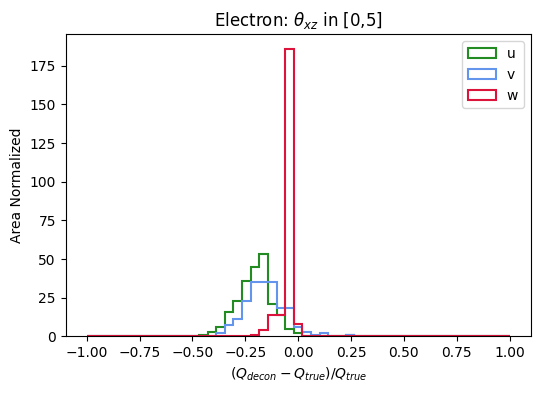

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


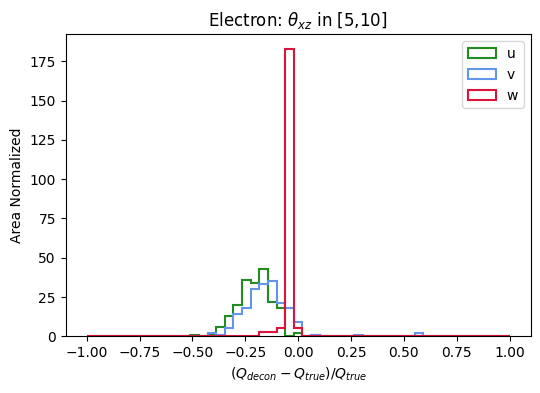

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


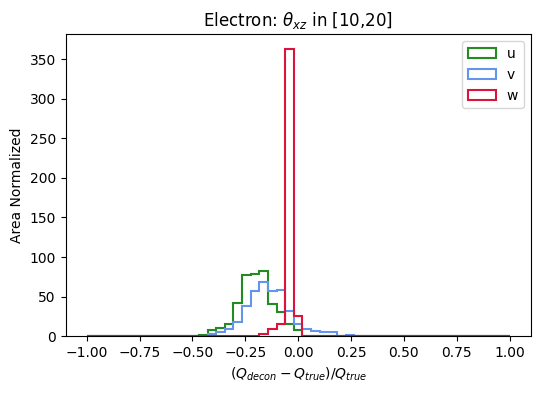

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


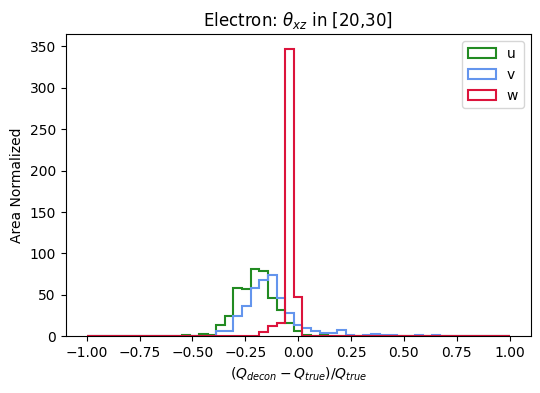

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


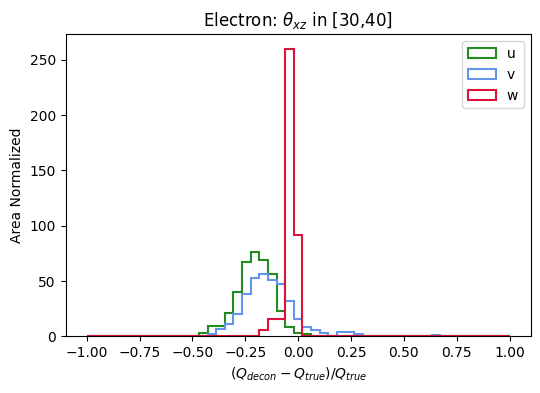

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


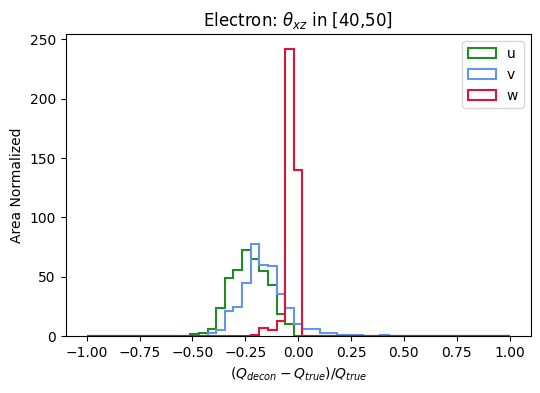

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


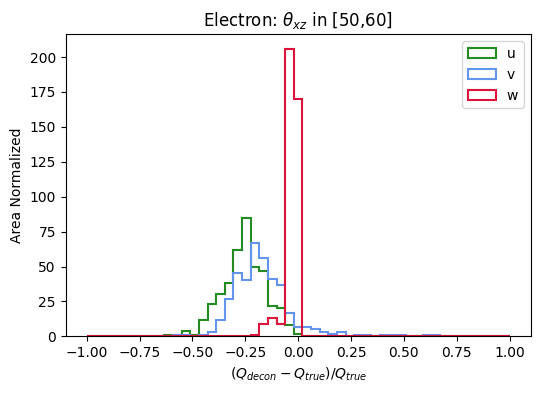

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


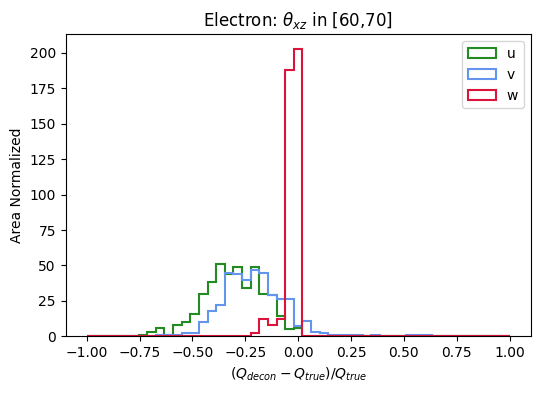

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


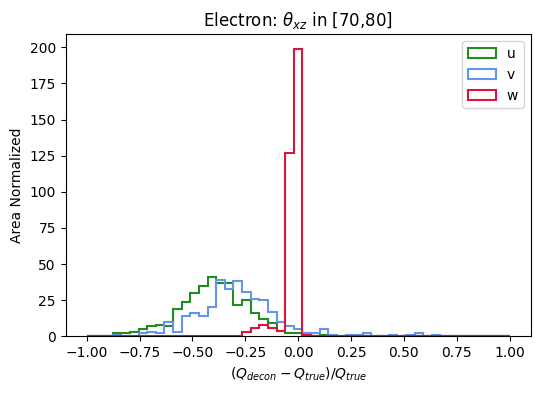

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


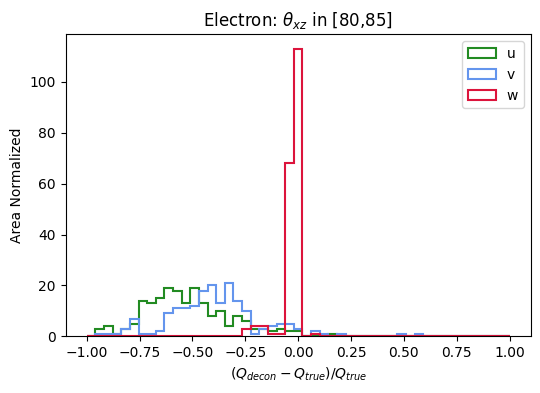

In [44]:
for i in range(len(ticks)-1):
    plt.figure(dpi=100)
    lower = ticks[i]
    upper = ticks[i+1]
    mask = np.where((theta_xz_arr < upper) & (theta_xz_arr >= lower),True,False)
    u_fail = np.where(((u_dec_arr/u_sim_arr) < 0.1) | ((u_dec_arr-u_sim_arr)/u_sim_arr > 2),True,False)
    v_fail = np.where(((v_dec_arr/v_sim_arr) < 0.1) | ((v_dec_arr-v_sim_arr)/v_sim_arr > 2),True,False)
    w_fail = np.where(((w_dec_arr/w_sim_arr) < 0.1) | ((w_dec_arr-w_sim_arr)/w_sim_arr > 2),True,False)
    plt.hist(u_diff_arr[mask & (u_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    plt.hist(v_diff_arr[mask & (v_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    plt.hist(w_diff_arr[mask & (w_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    plt.legend()
    plt.ylabel("Area Normalized")
    plt.xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    plt.title(fr"Electron: $\theta_{{xz}}$ in [{lower},{upper}]")
    # plt.yscale("log")
    plt.show()

In [35]:
ticklabels = []
for i, angle in enumerate(ticks):
    ticklabels.append(str(int(angle)) + "(" + str(int(ticks_prime[i])) + ")")

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


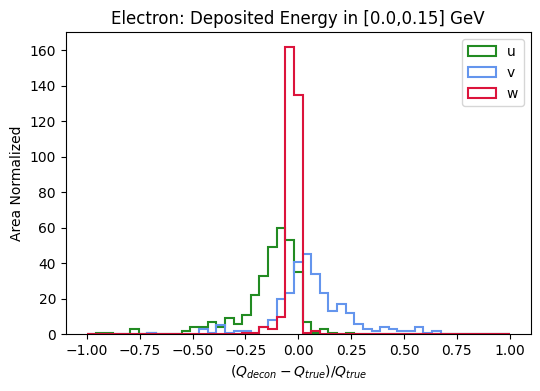

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


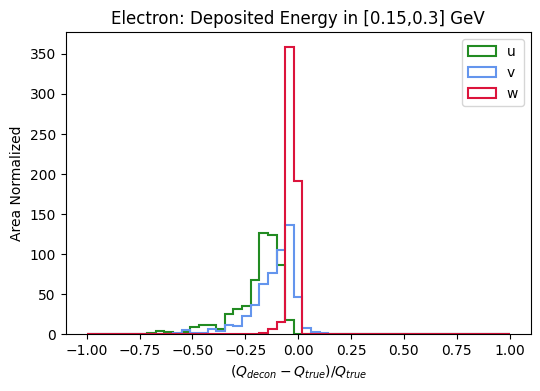

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


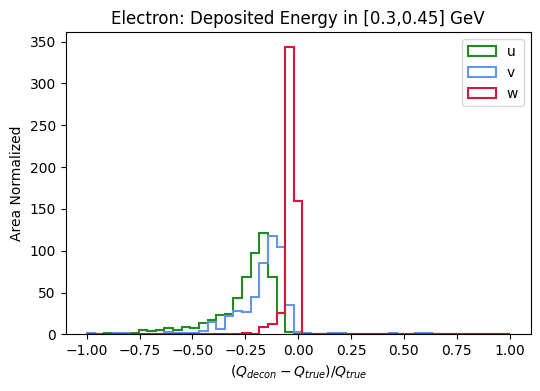

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


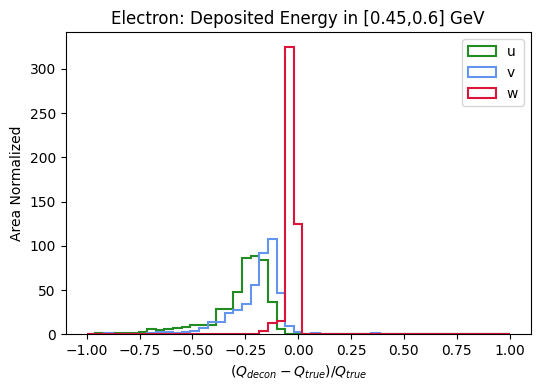

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


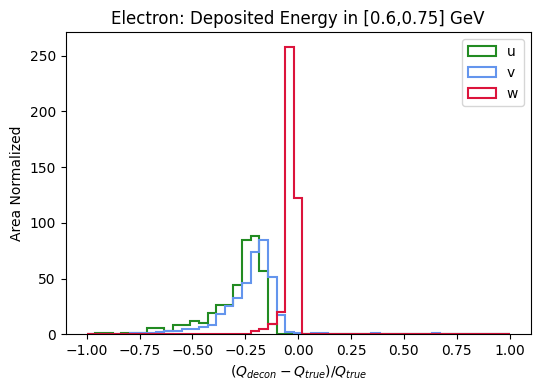

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


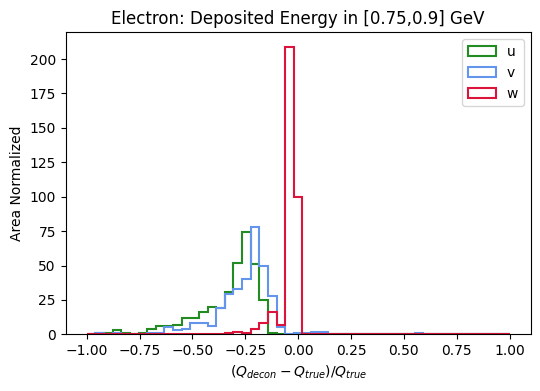

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


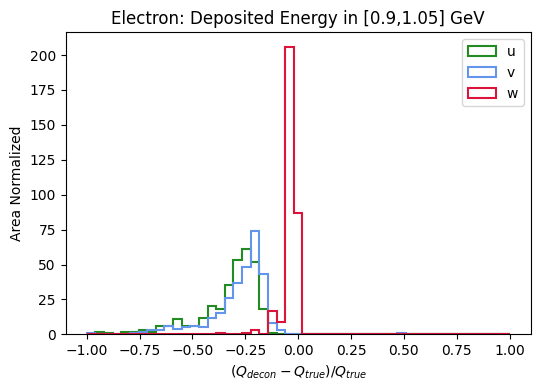

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


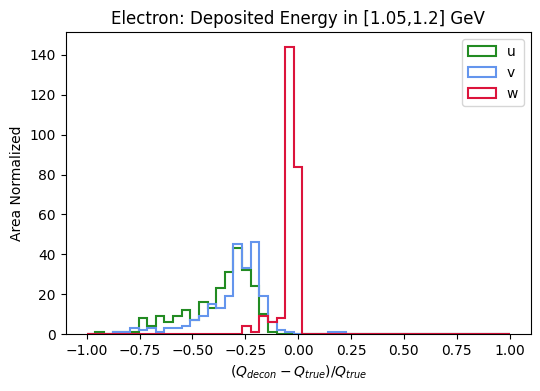

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


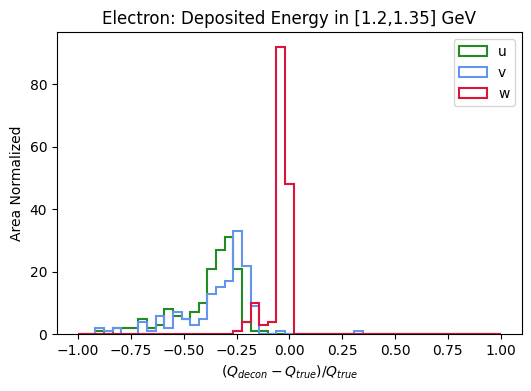

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


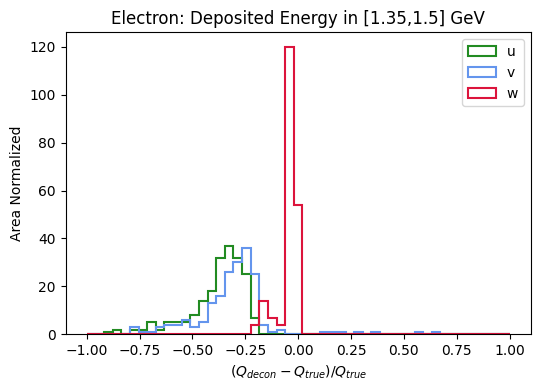

In [45]:
energy_bins = np.linspace(0,1.5,11)
for i in range(len(energy_bins)-1):
    plt.figure(dpi=100)
    lower = energy_bins[i]
    upper = energy_bins[i+1]
    mask = np.where((depE_arr < upper) & (depE_arr >= lower),True,False)
    u_fail = np.where(((u_dec_arr/u_sim_arr) < 0.1) | ((u_dec_arr-u_sim_arr)/u_sim_arr > 2),True,False)
    v_fail = np.where(((v_dec_arr/v_sim_arr) < 0.1) | ((v_dec_arr-v_sim_arr)/v_sim_arr > 2),True,False)
    w_fail = np.where(((w_dec_arr/w_sim_arr) < 0.1) | ((w_dec_arr-w_sim_arr)/w_sim_arr > 2),True,False)
    plt.hist(u_diff_arr[mask & (u_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    plt.hist(v_diff_arr[mask & (v_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    plt.hist(w_diff_arr[mask & (w_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    plt.legend()
    plt.ylabel("Area Normalized")
    plt.xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    plt.title(fr"Electron: Deposited Energy in [{round(lower,3)},{round(upper,3)}] GeV")
    # plt.yscale("log")
    plt.show()

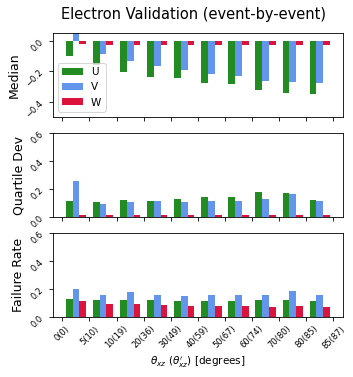

In [41]:
fig, axes = plt.subplots(3,1,figsize=(5,5),sharex=True,dpi=75)
# plt.subplots_adjust(hspace=0.08)
N=10
width = 0.25
# ticklabels = ["0","5","10","20","30","40","50","60","70","80","85"]
axes[0].set_xticks(np.arange(N+1)-0.5)
axes[0].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[0].bar(np.arange(N)-width, u_mean,width=width,label="U",color="forestgreen")
axes[0].bar(np.arange(N)      , v_mean,width=width,label="V",color="cornflowerblue")
axes[0].bar(np.arange(N)+width, w_mean,width=width,label="W",color="crimson")
axes[0].set_ylabel("Median",fontsize=12)
axes[0].legend()
axes[0].set_ylim(-0.50,0.05)

axes[1].bar(np.arange(N)-width,u_stdd,width=width,label="U",color="forestgreen")
axes[1].bar(np.arange(N),      v_stdd,width=width,label="V",color="cornflowerblue")
axes[1].bar(np.arange(N)+width,w_stdd,width=width,label="W",color="crimson")
axes[1].set_ylabel("Quartile Dev",fontsize=12)
axes[1].tick_params(labelbottom=False)
axes[1].set_yticks([0.0,0.2,0.4,0.6])
axes[1].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_ylim(0,0.6)

axes[2].bar(np.arange(N)-width,u_efff,width=width,label="U",color="forestgreen")
axes[2].bar(np.arange(N),      v_efff,width=width,label="V",color="cornflowerblue")
axes[2].bar(np.arange(N)+width,w_efff,width=width,label="W",color="crimson")
axes[2].set_ylabel("Failure Rate",fontsize=12)
axes[2].tick_params(labelbottom=True)
axes[2].set_yticks([0.0,0.2,0.4,0.6])
axes[2].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[2].set_xticklabels(ticklabels)
axes[2].xaxis.set_tick_params(labelsize=8,rotation=45)
axes[2].set_xlabel(r"$\theta_{xz}$ ($\theta_{xz}'$) [degrees]")
axes[2].set_ylim(0,0.6)

plt.suptitle("Electron Validation (event-by-event)",fontsize=14,y=0.95)
plt.show()

# Low Energy Investigation

In [38]:
this_df = df[df.depE < 0.15]

